In [ ]:
pip install earthengine-api

In [ ]:
import ee
ee.Authenticate()
ee.Initialize(project='ee-saadlkhder02')

In [ ]:
# Définir la région Fès-Meknès (rectangle approximatif)
roi_fes_meknes = ee.Geometry.Rectangle([-5.8, 33.0, -3.0, 34.5])

# Définir la période
start_date = "2018-01-01"
end_date = "2025-04-05"


In [ ]:
# Load Landsat 8 imagery
landsat = ee.ImageCollection("LANDSAT/LC08/C01/T1_SR") \
    .filterBounds(roi_fes_meknes) \
    .filterDate(start_date, end_date) \
    .filter(ee.Filter.lt("CLOUD_COVER", 10))  # Filter out cloudy images

# Function to calculate NDVI
def calculate_ndvi(image):
    ndvi = image.normalizedDifference(["B5", "B4"]).rename("NDVI")
    return image.addBands(ndvi)

# Apply the NDVI function to the image collection
landsat_ndvi = landsat.map(calculate_ndvi)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
# Charger la collection Landsat 8
landsat = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
    .filterBounds(roi_fes_meknes) \
    .filterDate(start_date, end_date) \
    .filter(ee.Filter.lt("CLOUD_COVER", 10))

# Vérifier si la collection contient des images
landsat_size = landsat.size().getInfo()
if landsat_size == 0:
    raise ValueError("Aucune image trouvée avec les critères de sélection.")

print(f"{landsat_size} images trouvées dans la collection")

# Fonction pour calculer le NDVI
def calculate_ndvi(image):
    ndvi = image.normalizedDifference(["SR_B5", "SR_B4"]).rename("NDVI")
    return image.addBands(ndvi)

# Appliquer la fonction NDVI
landsat_ndvi = landsat.map(calculate_ndvi)

# Récupérer les données de NDVI
try:
    # Obtenir les informations de région (cette opération est asynchrone)
    ndvi_time_series = landsat_ndvi.getRegion(
        geometry=roi_fes_meknes,
        scale=100,
        crs='EPSG:4326'
    ).getInfo()  # getInfo() force l'exécution de la requête

    # Convertir en DataFrame pandas
    import pandas as pd
    headers = ndvi_time_series[0]
    data = ndvi_time_series[1:]
    df = pd.DataFrame(data, columns=headers)

    # Traitement des données
    df['time'] = pd.to_datetime(df['time'], unit='ms')
    df['NDVI'] = pd.to_numeric(df['NDVI'])
    df = df.dropna(subset=['NDVI'])

    # Sauvegarder
    df.to_csv("ndvi_time_series.csv", index=False)
    print("Fichier CSV créé avec succès")

except ee.EEException as e:
    print(f"Erreur Earth Engine: {str(e)}")
except Exception as e:
    print(f"Erreur inattendue: {str(e)}")
    import matplotlib.pyplot as plt
import pandas as pd



560 images trouvées dans la collection
Erreur Earth Engine: ImageCollection.getRegion: Too many values: 5205042 points x 20 bands x 560 images > 1048576.


In [ ]:
import ee
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm




# Définir la géométrie approximative de Fès-Meknès
roi_fes_meknes = ee.Geometry.Rectangle([-5.8, 33.0, -3.0, 34.5])

# Définir la période
start_date = "2018-01-01"
end_date = "2025-01-01"

# Charger la collection Landsat 8
landsat = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
    .filterBounds(roi_fes_meknes) \
    .filterDate(start_date, end_date) \
    .filter(ee.Filter.lt("CLOUD_COVER", 10))

# Fonction pour calculer NDVI moyen pour chaque image
def get_ndvi_feature(image):
    ndvi = image.normalizedDifference(["SR_B5", "SR_B4"]).rename("NDVI")
    date = image.date().format("YYYY-MM-dd")
    mean_dict = ndvi.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=roi_fes_meknes,
        scale=100,
        maxPixels=1e9
    )
    return ee.Feature(None, {
        'date': date,
        'NDVI': mean_dict.get('NDVI')
    })

# Appliquer la fonction à chaque image
ndvi_fc = landsat.map(get_ndvi_feature)

# Extraire la liste de Features
features = ndvi_fc.toList(ndvi_fc.size())
ndvi_data = []
for i in tqdm(range(features.size().getInfo()) , desc="Extraction NDVI"):
    f = ee.Feature(features.get(i)).getInfo()
    props = f['properties']
    if 'NDVI' in props and props['NDVI'] is not None:
        ndvi_data.append({
            'date': props['date'],
            'NDVI': props['NDVI']
        })

# Créer un DataFrame propre
df = pd.DataFrame(ndvi_data)
df["date"] = pd.to_datetime(df["date"])
df["NDVI"] = pd.to_numeric(df["NDVI"], errors="coerce")
df = df.dropna()

# Regrouper par date (au cas où il y a plusieurs NDVI par jour)
df_mean = df.groupby("date").mean().reset_index()

# Ajouter un lissage (moyenne mobile)
df_mean["NDVI_smoothed"] = df_mean["NDVI"].rolling(window=5, center=True).mean()

# Sauvegarder les deux CSV
df.to_csv("ndvi_raw_fes_meknes.csv", index=False)
df_mean.to_csv("ndvi_grouped_smoothed_fes_meknes.csv", index=False)
print("✅ CSV exportés avec succès")

# Tracer la courbe lissée
plt.figure(figsize=(12, 6))
plt.plot(df_mean["date"], df_mean["NDVI_smoothed"], color="green", label="NDVI lissé")
plt.title("NDVI moyen lissé - Fès-Meknès (2018-2025)")
plt.xlabel("Date")
plt.ylabel("NDVI")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("ndvi_lisse_fes_meknes.png")
plt.show()


Extraction NDVI:  97%|█████████▋| 522/540 [16:37<00:13,  1.30it/s]

URL du thumbnail généré : https://earthengine.googleapis.com/v1/projects/ee-saadlkhder02/thumbnails/83e459914261b81e1ff7e8c26dfe3f31-3323b6896098483c50f7ae7e1a92cd73:getPixels
✅ Carte sauvegardée avec succès sous le nom : carte_ndvi_moyen_fes_meknes.png


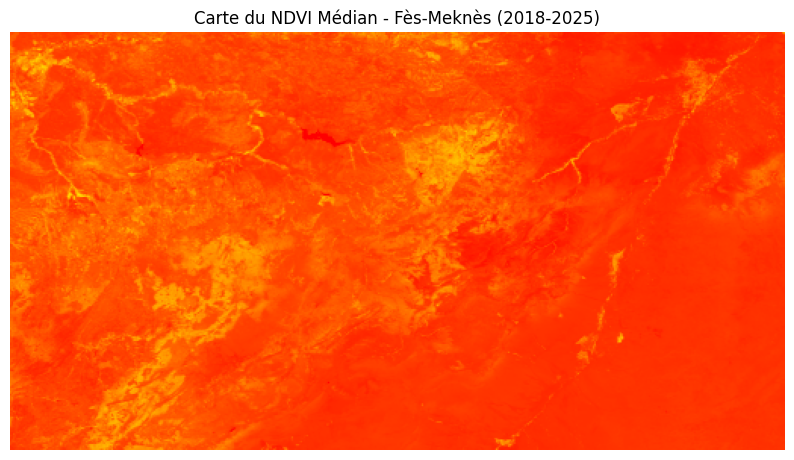

In [ ]:
import ee
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt


# 1. Définir la région et la période
roi_fes_meknes = ee.Geometry.Rectangle([-5.8, 33.0, -3.0, 34.5])
start_date = "2018-01-01"
end_date = "2025-01-01" # Fin de la période d'analyse

# 2. Obtenir la collection d'images Landsat 8 et calculer le NDVI
def calculate_ndvi(image):
    return image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')

landsat_collection = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filterBounds(roi_fes_meknes) \
    .filterDate(start_date, end_date) \
    .filter(ee.Filter.lt('CLOUD_COVER', 20)) \
    .map(calculate_ndvi)

# 3. Créer une seule image en prenant la médiane de toutes les images
# La médiane est robuste aux valeurs extrêmes (nuages résiduels, etc.)
median_ndvi = landsat_collection.median()

# 4. Définir les paramètres de visualisation pour le NDVI
# Palette de couleurs allant du rouge (végétation faible) au vert (végétation forte)
vis_params_ndvi = {
    'min': 0.0,
    'max': 0.8,
    'palette': ['red', 'yellow', 'green']
}

# 5. Obtenir l'URL d'une image miniature (thumbnail)
thumbnail_url = median_ndvi.getThumbURL({
    'dimensions': 512,  # Taille de l'image en pixels
    'region': roi_fes_meknes,
    'format': 'png',
    **vis_params_ndvi # Intégration des paramètres de visualisation
})

print("URL du thumbnail généré :", thumbnail_url)

# 6. Télécharger et afficher l'image
try:
    response = requests.get(thumbnail_url)
    img = Image.open(BytesIO(response.content))

    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.title('Carte du NDVI Médian - Fès-Meknès (2018-2025)')
    plt.axis('off') # Cacher les axes X et Y

    # Sauvegarder la carte
    nom_carte_sortie = "carte_ndvi_moyen_fes_meknes.png"
    plt.savefig(nom_carte_sortie, dpi=300, bbox_inches='tight')
    print(f"✅ Carte sauvegardée avec succès sous le nom : {nom_carte_sortie}")

    plt.show()

except Exception as e:
    print(f"Erreur lors du téléchargement ou de l'affichage de l'image : {e}")

In [ ]:
!pip install folium --upgrade # Upgrade to the latest version of folium

🔄 Traitement de l'année 2018


Année 2018: 100%|██████████| 364/364 [33:45<00:00,  5.56s/it]


🔄 Traitement de l'année 2019


Année 2019: 100%|██████████| 364/364 [41:34<00:00,  6.85s/it]


🔄 Traitement de l'année 2020


Année 2020: 100%|██████████| 365/365 [34:49<00:00,  5.72s/it]


🔄 Traitement de l'année 2021


Année 2021: 100%|██████████| 364/364 [40:54<00:00,  6.74s/it]


🔄 Traitement de l'année 2022


Année 2022: 100%|██████████| 364/364 [38:39<00:00,  6.37s/it]


🔄 Traitement de l'année 2023


Année 2023: 100%|██████████| 364/364 [36:05<00:00,  5.95s/it]


🔄 Traitement de l'année 2024


Année 2024: 100%|██████████| 365/365 [35:52<00:00,  5.90s/it]


🔄 Traitement de l'année 2025


Année 2025: 100%|██████████| 143/143 [06:25<00:00,  2.70s/it]


✅ Extraction terminée et CSV exporté.


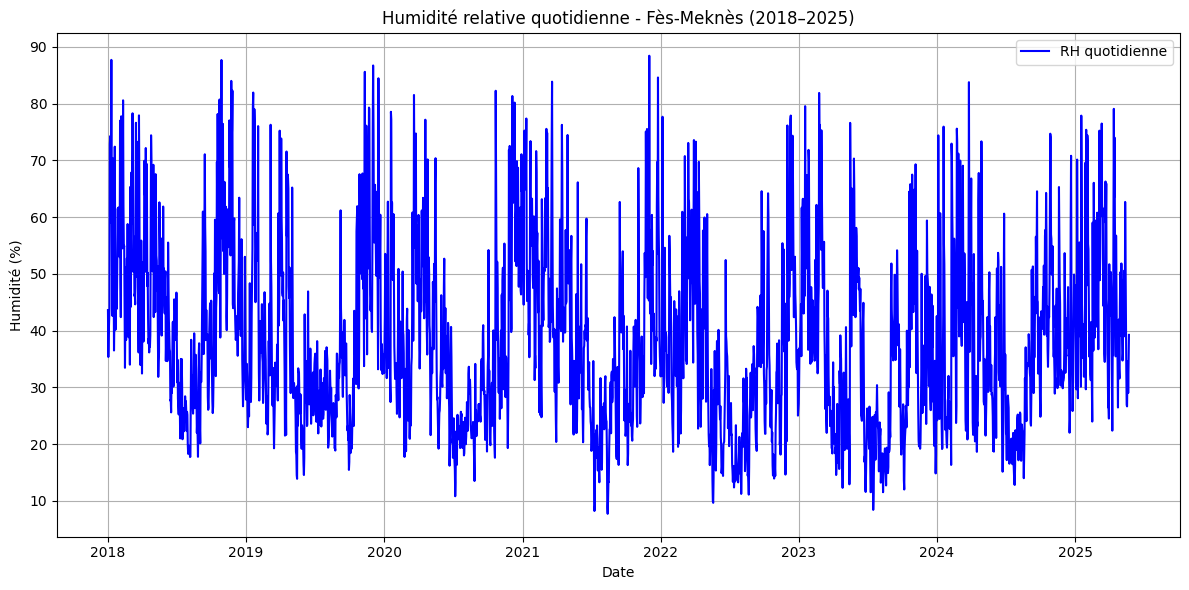

In [ ]:
import ee
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm


roi_fes_meknes = ee.Geometry.Rectangle([-5.8, 33.0, -3.0, 34.5])
years = list(range(2018, 2026))  # 2018 à 2025 inclus

all_rh = []

for year in years:
    print(f"🔄 Traitement de l'année {year}")
    start = f"{year}-01-01"
    end = f"{year}-12-31"

    era5 = ee.ImageCollection("ECMWF/ERA5_LAND/HOURLY") \
        .filterBounds(roi_fes_meknes) \
        .filterDate(start, end) \
        .filter(ee.Filter.calendarRange(12, 12, 'hour')) \
        .select(["temperature_2m", "dewpoint_temperature_2m"])

    def compute_relative_humidity(image):
        temp = image.select("temperature_2m").subtract(273.15)
        dew = image.select("dewpoint_temperature_2m").subtract(273.15)
        es = temp.multiply(17.625).divide(temp.add(243.04)).exp()
        ed = dew.multiply(17.625).divide(dew.add(243.04)).exp()
        rh = ed.divide(es).multiply(100).rename("RH")

        mean_rh = rh.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=roi_fes_meknes,
            scale=1000,
            maxPixels=1e9
        )

        return ee.Feature(None, {
            "date": image.date().format("YYYY-MM-dd"),
            "RH": mean_rh.get("RH")
        })

    rh_fc = era5.map(compute_relative_humidity)
    features = rh_fc.toList(rh_fc.size())
    for i in tqdm(range(features.size().getInfo()), desc=f"Année {year}"):
        f = ee.Feature(features.get(i)).getInfo()
        props = f["properties"]
        if "RH" in props and props["RH"] is not None:
            all_rh.append({
                "date": props["date"],
                "RH": props["RH"]
            })

# Convertir en DataFrame
df_rh = pd.DataFrame(all_rh)
df_rh["date"] = pd.to_datetime(df_rh["date"])
df_rh["RH"] = pd.to_numeric(df_rh["RH"], errors="coerce")
df_rh = df_rh.dropna()

# Sauvegarde
df_rh.to_csv("humidite_relative_fes_meknes.csv", index=False)
print("✅ Extraction terminée et CSV exporté.")

# Graphique
plt.figure(figsize=(12, 6))
plt.plot(df_rh["date"], df_rh["RH"], color="blue", label="RH quotidienne")
plt.title("Humidité relative quotidienne - Fès-Meknès (2018–2025)")
plt.xlabel("Date")
plt.ylabel("Humidité (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("humidite_relative_fes_meknes.png", dpi=300)
plt.show()


Extraction précipitations: 100%|██████████| 2557/2557 [1:39:08<00:00,  2.33s/it]


Série temporelle des précipitations exportée


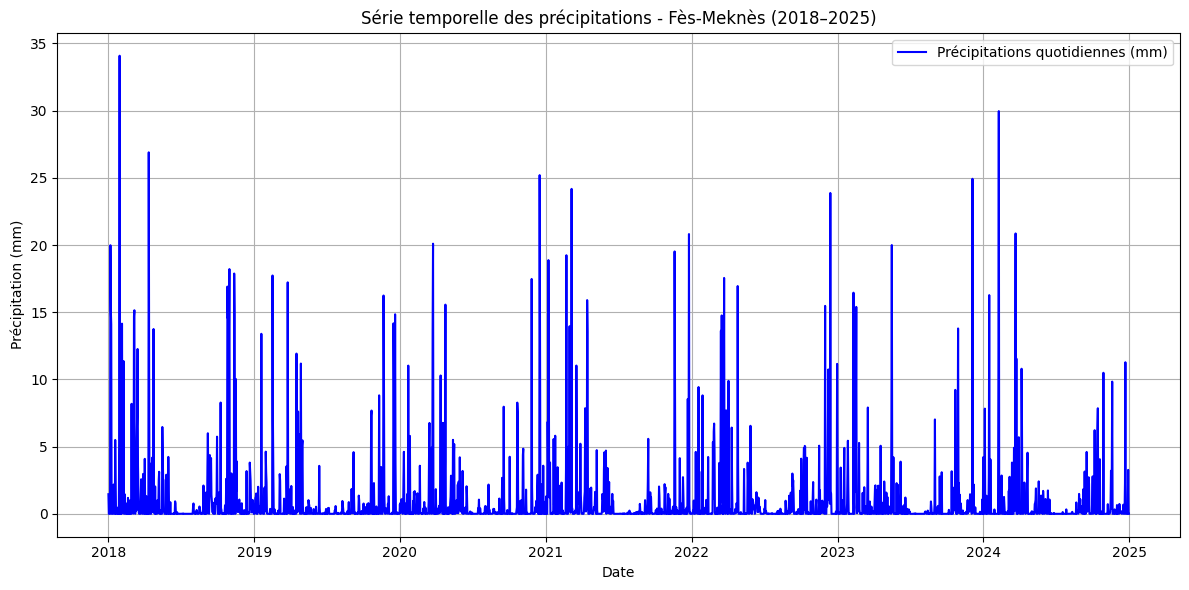

In [ ]:
import ee
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm


# Définir la région
roi_fes_meknes = ee.Geometry.Rectangle([-5.8, 33.0, -3.0, 34.5])

# Définir la période d'analyse
start_date = "2018-01-01"
end_date = "2025-01-01"

# Charger la collection CHIRPS
chirps = ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY") \
    .filterBounds(roi_fes_meknes) \
    .filterDate(start_date, end_date) \
    .select("precipitation")

# Fonction pour extraire la précipitation moyenne par image
def extract_daily_precip(image):
    date = image.date().format("YYYY-MM-dd")
    mean_rain = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=roi_fes_meknes,
        scale=5000,
        maxPixels=1e9
    )
    return ee.Feature(None, {
        "date": date,
        "precipitation": mean_rain.get("precipitation")
    })

# Appliquer la fonction à chaque image
rain_fc = chirps.map(extract_daily_precip)

# Extraire les données
features = rain_fc.toList(rain_fc.size())
rain_data = []
for i in tqdm(range(features.size().getInfo()), desc="Extraction précipitations"):
    f = ee.Feature(features.get(i)).getInfo()
    props = f["properties"]
    if "precipitation" in props and props["precipitation"] is not None:
        rain_data.append({
            "date": props["date"],
            "precipitation": props["precipitation"]
        })

# Convertir en DataFrame
df_rain = pd.DataFrame(rain_data)
df_rain["date"] = pd.to_datetime(df_rain["date"])
df_rain["precipitation"] = pd.to_numeric(df_rain["precipitation"], errors="coerce")
df_rain = df_rain.dropna()

# Sauvegarder le CSV
df_rain.to_csv("serie_precipitation_fes_meknes.csv", index=False)
print("Série temporelle des précipitations exportée")

# Tracer la courbe
plt.figure(figsize=(12, 6))
plt.plot(df_rain["date"], df_rain["precipitation"], color="blue", label="Précipitations quotidiennes (mm)")
plt.title("Série temporelle des précipitations - Fès-Meknès (2018–2025)")
plt.xlabel("Date")
plt.ylabel("Précipitation (mm)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("serie_precipitation_fes_meknes.png", dpi=300)
plt.show()


🔄 Traitement de la température pour l'année 2018


Extraction température 2018: 100%|██████████| 364/364 [33:58<00:00,  5.60s/it]


🔄 Traitement de la température pour l'année 2019


Extraction température 2019: 100%|██████████| 364/364 [33:03<00:00,  5.45s/it]


🔄 Traitement de la température pour l'année 2020


Extraction température 2020: 100%|██████████| 365/365 [33:02<00:00,  5.43s/it]


🔄 Traitement de la température pour l'année 2021


Extraction température 2021: 100%|██████████| 364/364 [32:15<00:00,  5.32s/it]


🔄 Traitement de la température pour l'année 2022


Extraction température 2022: 100%|██████████| 364/364 [31:16<00:00,  5.16s/it]


🔄 Traitement de la température pour l'année 2023


Extraction température 2023: 100%|██████████| 364/364 [33:47<00:00,  5.57s/it]


🔄 Traitement de la température pour l'année 2024


Extraction température 2024: 100%|██████████| 365/365 [33:19<00:00,  5.48s/it]


🔄 Traitement de la température pour l'année 2025


Extraction température 2025: 100%|██████████| 144/144 [06:41<00:00,  2.79s/it]


Série temporelle de température exportée


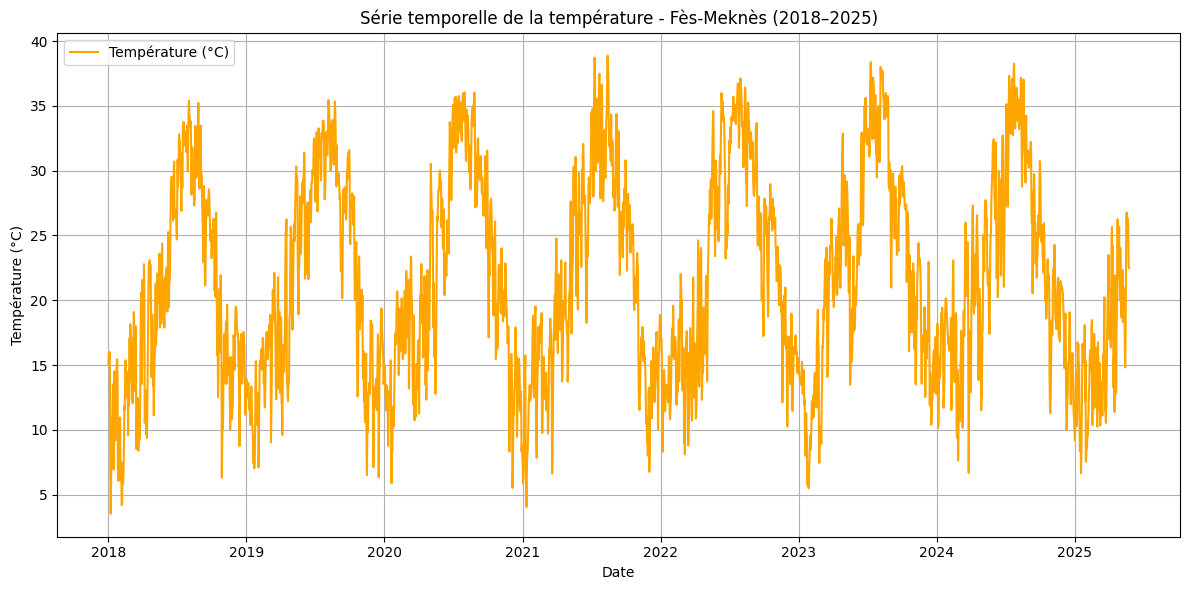

In [ ]:
import ee
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Initialiser Earth Engine (si ce n'est pas déjà fait dans votre session)
# ee.Authenticate() # Exécutez si nécessaire
# ee.Initialize(project='ee-saadlkhder02') # Remplacez par votre projet

# Définir la région Fès-Meknès
roi_fes_meknes = ee.Geometry.Rectangle([-5.8, 33.0, -3.0, 34.5])
years = list(range(2018, 2026)) # 2018 à 2025 inclus

all_temp_data = [] # Liste pour agréger les données de toutes les années

# Fonction pour extraire la température moyenne par jour (identique à la vôtre)
def extract_daily_temp(image):
    date = image.date().format("YYYY-MM-dd")
    temp_c = image.select("temperature_2m").subtract(273.15)  # Convertir en °C
    mean_temp = temp_c.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=roi_fes_meknes,
        scale=1000,
        maxPixels=1e9
    )
    return ee.Feature(None, {
        "date": date,
        "temperature": mean_temp.get("temperature_2m")
    })

for year in years:
    print(f"🔄 Traitement de la température pour l'année {year}")
    start_date_year = f"{year}-01-01"
    end_date_year = f"{year}-12-31" # S'assurer de prendre toute l'année

    era5 = ee.ImageCollection("ECMWF/ERA5_LAND/HOURLY") \
        .filterBounds(roi_fes_meknes) \
        .filterDate(start_date_year, end_date_year) \
        .filter(ee.Filter.calendarRange(12, 12, 'hour')) \
        .select("temperature_2m")

    temp_fc_year = era5.map(extract_daily_temp)

    # Limiter le nombre d'éléments récupérés par getInfo() à la fois
    # En traitant année par année, la taille de la liste est plus gérable
    features_year = temp_fc_year.toList(temp_fc_year.size()) # .size() ici est pour l'année en cours

    for i in tqdm(range(features_year.size().getInfo()), desc=f"Extraction température {year}"):
        f = ee.Feature(features_year.get(i)).getInfo()
        props = f["properties"]
        if "temperature" in props and props["temperature"] is not None:
            all_temp_data.append({
                "date": props["date"],
                "temperature": props["temperature"]
            })

# Convertir en DataFrame
df_temp = pd.DataFrame(all_temp_data)
df_temp["date"] = pd.to_datetime(df_temp["date"])
df_temp["temperature"] = pd.to_numeric(df_temp["temperature"], errors="coerce")
df_temp = df_temp.dropna()
df_temp = df_temp.sort_values(by='date') # S'assurer que les données sont triées par date

# Sauvegarder le CSV
df_temp.to_csv("serie_temperature_fes_meknes.csv", index=False)
print("Série temporelle de température exportée")

# Tracer la courbe (identique à votre code)
plt.figure(figsize=(12, 6))
plt.plot(df_temp["date"], df_temp["temperature"], color="orange", label="Température (°C)")
plt.title("Série temporelle de la température - Fès-Meknès (2018–2025)")
plt.xlabel("Date")
plt.ylabel("Température (°C)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("serie_temperature_fes_meknes.png", dpi=300)
plt.show()

In [ ]:
import pandas as pd

# Charger chaque série temporelle
df_ndvi = pd.read_csv("ndvi_grouped_smoothed_fes_meknes.csv")
df_precip = pd.read_csv("serie_precipitation_fes_meknes.csv")
df_temp = pd.read_csv("serie_temperature_fes_meknes.csv")
df_rh = pd.read_csv("humidite_relative_fes_meknes.csv")  # optionnel

# Convertir les dates en datetime
df_ndvi["date"] = pd.to_datetime(df_ndvi["date"])
df_precip["date"] = pd.to_datetime(df_precip["date"])
df_temp["date"] = pd.to_datetime(df_temp["date"])
df_rh["date"] = pd.to_datetime(df_rh["date"])


In [ ]:
# Fusion NDVI + Précipitations
df_all = pd.merge(df_ndvi, df_precip, on="date", how="inner")

# Fusion avec Température
df_all = pd.merge(df_all, df_temp, on="date", how="inner")

#  Fusion avec Humidité
df_all = pd.merge(df_all, df_rh, on="date", how="inner")


In [ ]:
print(df_all.isnull().sum())



date             0
NDVI             0
NDVI_smoothed    4
precipitation    0
temperature      0
RH               0
dtype: int64


In [ ]:
df_all_cleaned = df_all.dropna(subset=['NDVI_smoothed'])
print(df_all_cleaned.isnull().sum()) # Pour vérifier

date             0
NDVI             0
NDVI_smoothed    0
precipitation    0
temperature      0
RH               0
dtype: int64


In [ ]:

# Exporter le DataFrame fusionné et nettoyé en CSV
df_all_cleaned.to_csv("donnees1_fusionnees_fes_meknes_nettoyees.csv", index=False)

print("✅ DataFrame fusionné et nettoyé exporté avec succès vers 'donnees_fusionnees_fes_meknes_nettoyees.csv'")

✅ DataFrame fusionné et nettoyé exporté avec succès vers 'donnees_fusionnees_fes_meknes_nettoyees.csv'


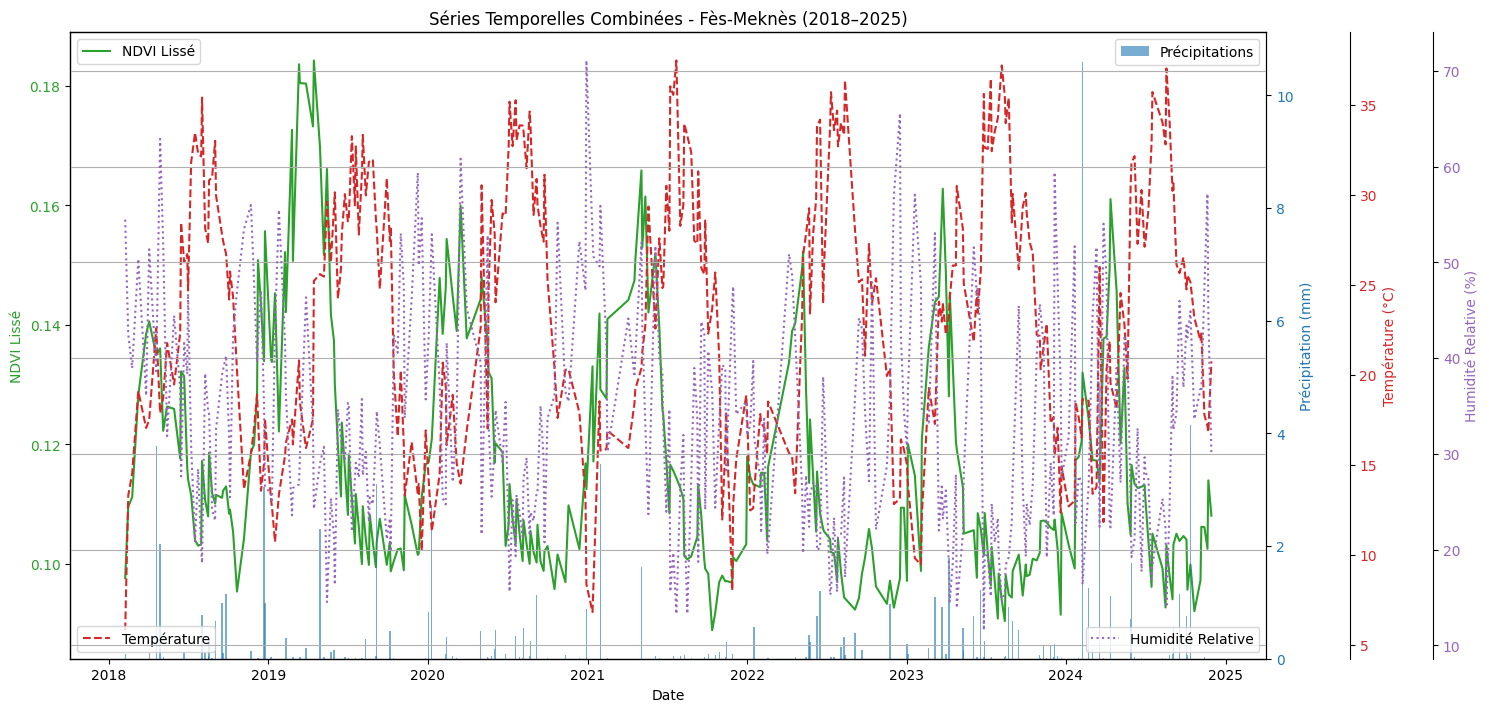

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd # Au cas où ce n'est pas déjà importé ou si vous redémarrez cette section

# Assurez-vous que df_all_nettoye est votre DataFrame final fusionné et nettoyé
# et que la colonne 'date' est bien au format datetime et est l'index (ou sera utilisée comme axe X)

# Si 'date' n'est pas l'index, mais une colonne :
# df_all_nettoye['date'] = pd.to_datetime(df_all_nettoye['date']) # S'assurer que c'est bien un datetime

fig, ax1 = plt.subplots(figsize=(15, 7))

# Axe 1 : NDVI lissé
color = 'tab:green'
ax1.set_xlabel('Date')
ax1.set_ylabel('NDVI Lissé', color=color)
ax1.plot(df_all_cleaned['date'], df_all_cleaned['NDVI_smoothed'], color=color, label='NDVI Lissé')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

# Axe 2 : Précipitations
# On crée un deuxième axe Y qui partage le même axe X (twinx)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Précipitation (mm)', color=color)
# Utiliser un graphique en barres pour les précipitations peut être plus lisible
ax2.bar(df_all_cleaned['date'], df_all_cleaned['precipitation'], color=color, alpha=0.6, label='Précipitations', width=3) # Ajustez 'width' si besoin
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

# Axe 3 : Température
# On crée un troisième axe Y
ax3 = ax1.twinx()
# Décaler l'axe de droite pour ne pas qu'il se superpose au deuxième
ax3.spines["right"].set_position(("outward", 60)) # 60 points de décalage
color = 'tab:red'
ax3.set_ylabel('Température (°C)', color=color)
ax3.plot(df_all_cleaned['date'], df_all_cleaned['temperature'], color=color, linestyle='--', label='Température')
ax3.tick_params(axis='y', labelcolor=color)
ax3.legend(loc='lower left')


# Axe 4 : Humidité Relative (RH)
# On crée un quatrième axe Y
ax4 = ax1.twinx()
ax4.spines["right"].set_position(("outward", 120)) # Décaler davantage
color = 'tab:purple'
ax4.set_ylabel('Humidité Relative (%)', color=color)
ax4.plot(df_all_cleaned['date'], df_all_cleaned['RH'], color=color, linestyle=':', label='Humidité Relative')
ax4.tick_params(axis='y', labelcolor=color)
ax4.legend(loc='lower right')


fig.tight_layout()  # Pour éviter que les labels des axes Y se chevauchent
plt.title('Séries Temporelles Combinées - Fès-Meknès (2018–2025)')
plt.grid(True) # Ajoute une grille pour faciliter la lecture
plt.show()

Matrice de Corrélation :
               NDVI_smoothed  precipitation  temperature        RH
NDVI_smoothed       1.000000       0.094830    -0.300134  0.077088
precipitation       0.094830       1.000000    -0.038303  0.005148
temperature        -0.300134      -0.038303     1.000000 -0.687324
RH                  0.077088       0.005148    -0.687324  1.000000


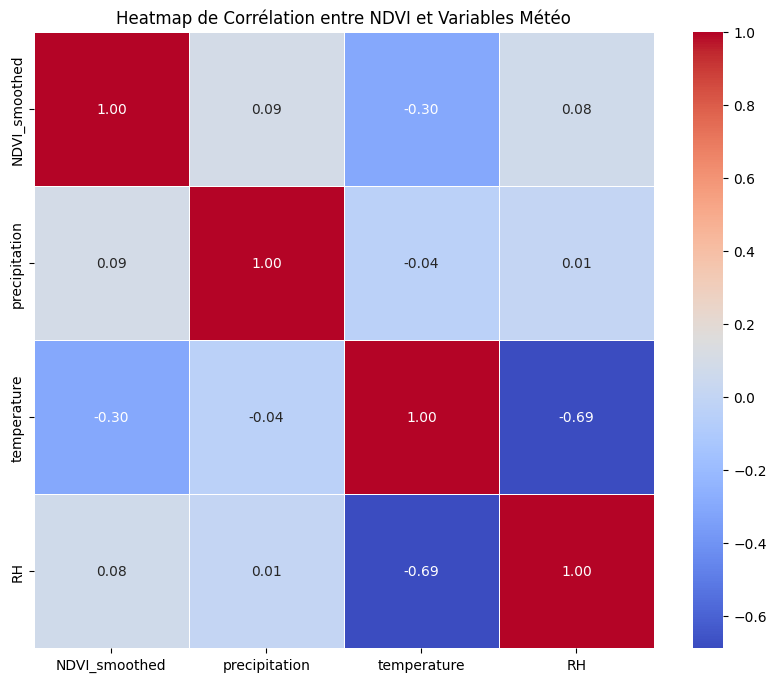

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd # Au cas où

# Assurez-vous que df_all est votre DataFrame final fusionné et nettoyé.
# Si vous l'avez appelé df_all_cleaned ou df_all_nettoye, utilisez ce nom.
VOTRE_DATAFRAME_NETTOYE = df_all_cleaned

# Sélectionner uniquement les colonnes numériques pertinentes pour la corrélation
# Si 'NDVI' (brut) est encore là et que vous préférez analyser avec 'NDVI_smoothed',
# vous pouvez l'exclure ou sélectionner explicitement les colonnes.
colonnes_pour_correlation = ['NDVI_smoothed', 'precipitation', 'temperature', 'RH']
df_pour_correlation = VOTRE_DATAFRAME_NETTOYE[colonnes_pour_correlation]

# Calculer la matrice de corrélation
matrice_correlation = df_pour_correlation.corr()

print("Matrice de Corrélation :")
print(matrice_correlation)

# Visualiser la matrice de corrélation avec une heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(matrice_correlation,
            annot=True,        # Afficher les valeurs de corrélation sur la carte
            cmap='coolwarm',   # Palette de couleurs (bleu pour négatif, rouge pour positif)
            fmt=".2f",         # Formatage des nombres à 2 décimales
            linewidths=.5)     # Lignes pour séparer les cellules
plt.title('Heatmap de Corrélation entre NDVI et Variables Météo')
plt.show()

# Sauvegarder la heatmap (optionnel)
nom_fichier_heatmap = "heatmap_correlation_fes_meknes.png"
# plt.savefig(nom_fichier_heatmap, dpi=300, bbox_inches='tight') # Décommentez pour sauvegarder
# print(f"✅ Heatmap sauvegardée avec succès sous le nom : {nom_fichier_heatmap}")




Matrice de Corrélation avec décalage temporel (focus sur NDVI):
NDVI_smoothed          1.000000
temperature_lag30      0.646660
RH_lag7                0.394546
RH_lag15               0.355667
RH_lag60               0.345239
RH                     0.112053
precipitation          0.091995
precipitation_lag45    0.038690
precipitation_lag60    0.026594
RH_lag45               0.023398
precipitation_lag15   -0.025249
precipitation_lag30   -0.074825
temperature_lag45     -0.141297
temperature           -0.287491
RH_lag30              -0.315983
temperature_lag15     -0.426555
temperature_lag60     -0.536069
temperature_lag7      -0.706630
Name: NDVI_smoothed, dtype: float64


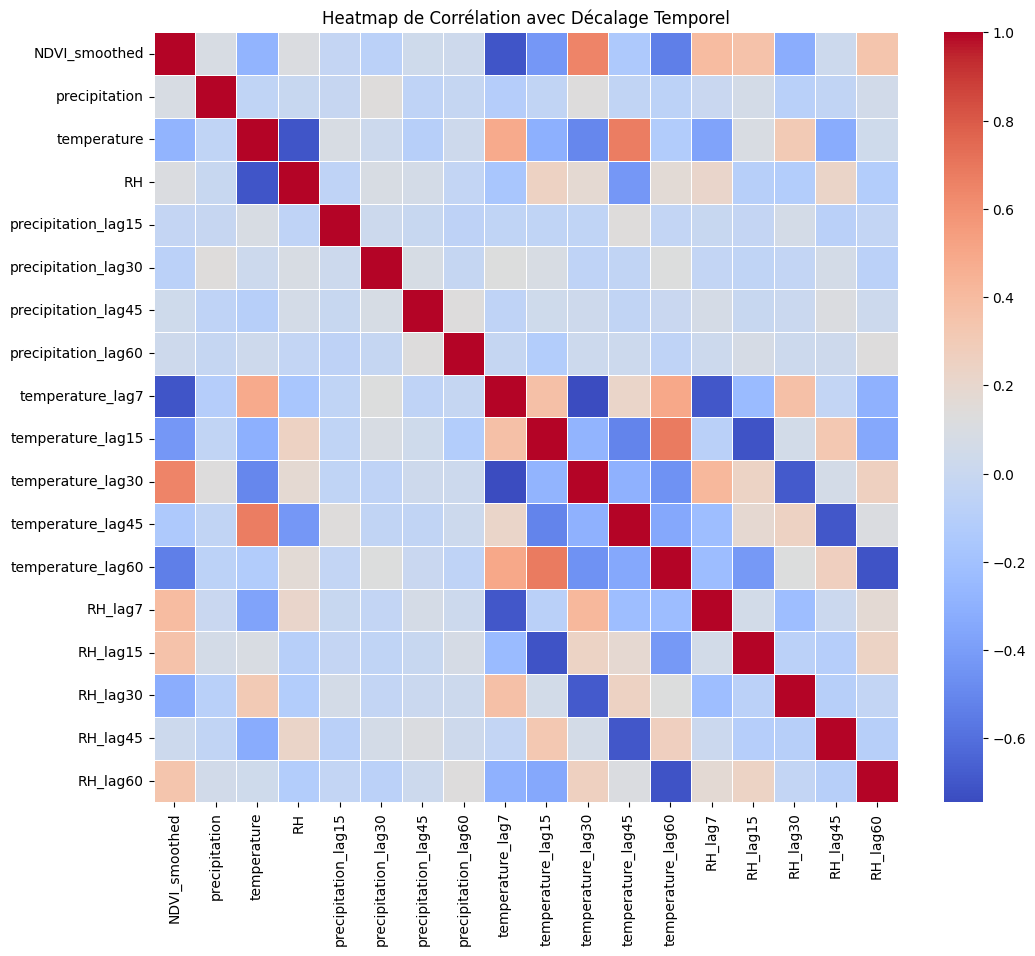

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Si vous avez utilisé un autre nom comme 'df_all_cleaned', utilisez celui-là.
VOTRE_DATAFRAME_NETTOYE = df_all_cleaned

# Créez une copie pour éviter de modifier le DataFrame original
df_lag = VOTRE_DATAFRAME_NETTOYE.copy()

# Définissez les décalages  (en jours)
# Par exemple, 15 jours, 30 jours (environ 1 mois), 45 jours, 60 jours
lags_precipitation = [15, 30, 45, 60]
lags_temperature = [7, 15, 30,45 , 60] # L'effet de la température peut être un peu plus rapide ou également décalé
lags_rh = [7, 15, 30, 45 , 60] # Similaire pour l'HR

for lag in lags_precipitation:
    df_lag[f'precipitation_lag{lag}'] = df_lag['precipitation'].shift(lag)

for lag in lags_temperature:
    df_lag[f'temperature_lag{lag}'] = df_lag['temperature'].shift(lag)

for lag in lags_rh:
    df_lag[f'RH_lag{lag}'] = df_lag['RH'].shift(lag)

# Colonnes à inclure dans la nouvelle matrice de corrélation
colonnes_pour_lag_correlation = ['NDVI_smoothed', 'precipitation', 'temperature', 'RH'] + \
                                [f'precipitation_lag{lag}' for lag in lags_precipitation] + \
                                [f'temperature_lag{lag}' for lag in lags_temperature] + \
                                [f'RH_lag{lag}' for lag in lags_rh]

# Supprimer les lignes avec des valeurs NaN qui ont été créées par l'opération de décalage
df_lag_cleaned = df_lag.dropna(subset=colonnes_pour_lag_correlation) # S'assurer de ne considérer que les lignes où toutes ces valeurs sont présentes

# Recalculer la matrice de corrélation
matrice_correlation_lag = df_lag_cleaned[colonnes_pour_lag_correlation].corr()

print("\nMatrice de Corrélation avec décalage temporel (focus sur NDVI):")
# Afficher les corrélations de NDVI_smoothed avec toutes les autres variables
print(matrice_correlation_lag['NDVI_smoothed'].sort_values(ascending=False))

# Visualiser la matrice de corrélation décalée complète (optionnel, peut être grande)
plt.figure(figsize=(12, 10)) # Ajustez la taille si besoin
sns.heatmap(matrice_correlation_lag, annot=False, cmap='coolwarm', fmt=".2f", linewidths=.5) # annot=False pour la lisibilité si trop de variables
plt.title('Heatmap de Corrélation avec Décalage Temporel')
plt.show()

## interpretation



temperature_lag30 : 0.646660 (Forte corrélation positive).
 C'est la corrélation la plus élevée et un changement majeur par rapport à la corrélation négative observée sans décalage (-0.287).
 Cela suggère fortement que des températures plus chaudes observées environ un mois avant sont associées à un NDVI plus élevé. Cela pourrait correspondre à la période de croissance où la chaleur (pas excessive) et l'ensoleillement favorisent la végétation, après d'éventuelles pluies printanières.

RH_lag7 : 0.394546 (Corrélation positive modérée)
RH_lag15 : 0.355667 (Corrélation positive modérée)
RH_lag60 : 0.345239 (Corrélation positive modérée) Ces résultats indiquent qu'une humidité relative plus élevée dans les 7 à 60 jours précédents est bénéfique pour la végétation.
RH (sans décalage) : 0.112053 (Faible corrélation positive, légèrement meilleure que le 0.08 initial).
precipitation (sans décalage) : 0.091995 (Faible corrélation positive, similaire au 0.09 initial).
precipitation_lag45 et precipitation_lag60 : Très faibles corrélations positives (autour de 0.03-0.04).
RH_lag45 : 0.023398 (Très faible corrélation positive).

precipitation_lag15 et precipitation_lag30 : Corrélations quasi nulles ou faiblement négatives (-0.025 et -0.075). Les précipitations, même avec un décalage, ne montrent toujours pas de corrélation linéaire forte avec le NDVI au jour le jour. C'est un point important. Cela ne signifie pas que la pluie n'est pas importante, mais que la relation n'est peut-être pas linéaire, ou que des accumulations sur des périodes plus longues (plutôt que la pluie d'un jour précis X jours avant) seraient plus pertinentes.
temperature_lag45 : -0.141297 (Faible corrélation négative).
temperature (sans décalage) : -0.287491 (Corrélation négative modérée, similaire au -0.30 initial).
RH_lag30 : -0.315983 (Corrélation négative modérée). C'est intéressant car l'HR sans décalage et avec des décalages plus courts était positive. Un mois après une période d'humidité élevée, le NDVI pourrait être plus bas si cette humidité était, par exemple, associée à moins d'ensoleillement ou à la fin d'une saison humide.
temperature_lag15 : -0.426555 (Corrélation négative modérée, plus forte que sans décalage).
temperature_lag60 : -0.536069 (Corrélation négative modérée à forte).
temperature_lag7 : -0.706630 (Forte corrélation négative). C'est la deuxième corrélation la plus forte. Elle suggère que des températures plus basses observées une semaine avant sont fortement associées à un NDVI plus élevé. Cela pourrait indiquer que des températures modérées ou une baisse de température après une période chaude sont bénéfiques.
Observations Clés et Implications :

Rôle Complexe de la Température :

La corrélation la plus forte et positive est avec temperature_lag30 (0.65).
La corrélation la plus forte et négative est avec temperature_lag7 (-0.71). Cela indique que la relation entre la température et le NDVI n'est pas simple. Des températures plus fraîches une semaine avant semblent bonnes (peut-être moins de stress hydrique), mais une période globalement plus chaude un mois avant (peut-être le début/milieu de la saison de croissance) est également positive. Cela met en évidence l'importance des cycles saisonniers.
Précipitations : L'impact direct de la pluie journalière, même décalée, reste faible dans cette analyse. Il serait peut-être plus judicieux d'analyser des cumuls de précipitations sur plusieurs semaines ou mois.

Humidité Relative : Une HR élevée dans les 7-15 jours précédents montre un impact positif modéré, ce qui est intuitif.

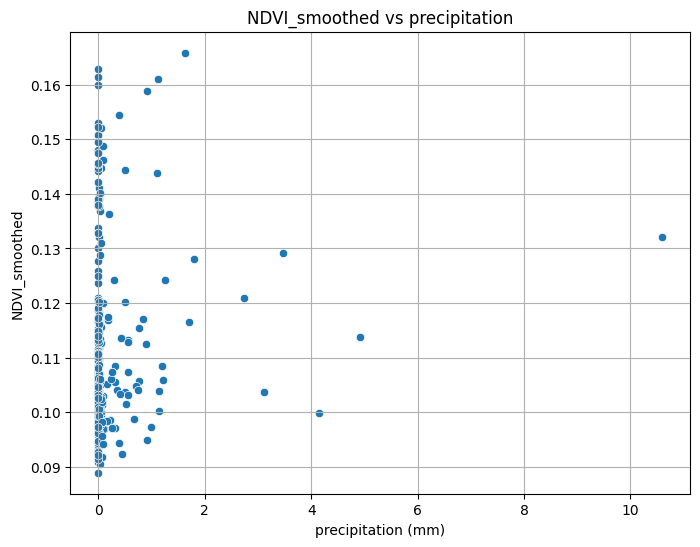

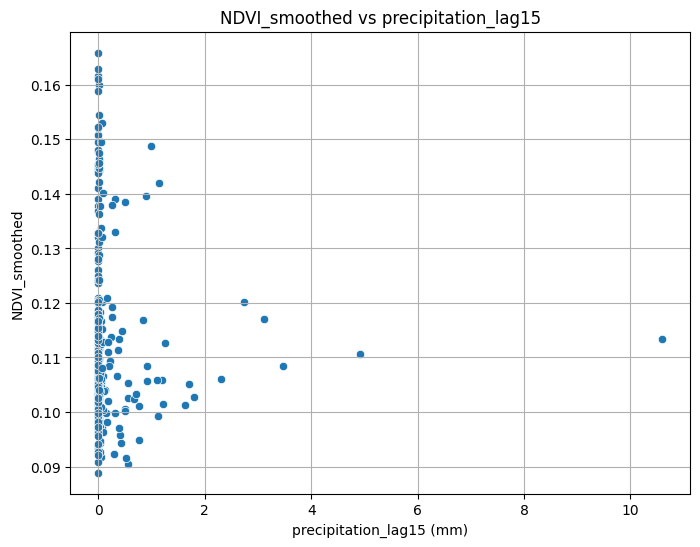

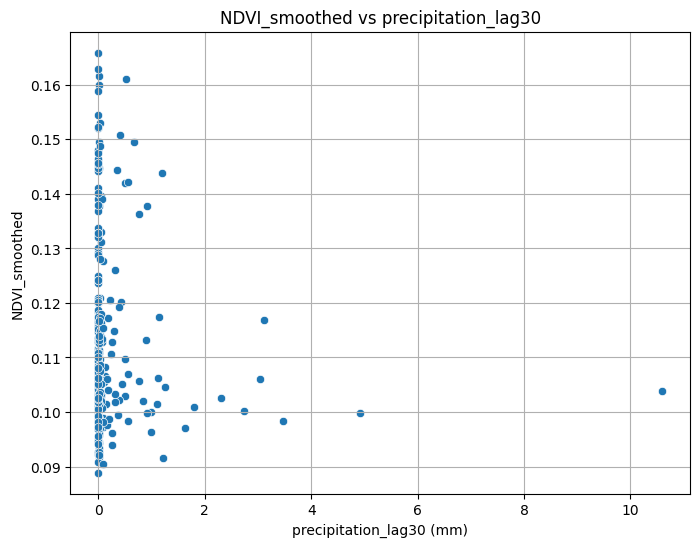

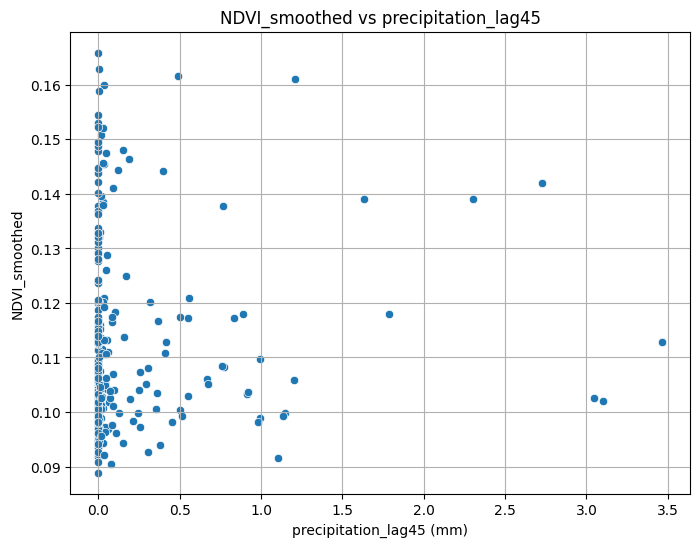

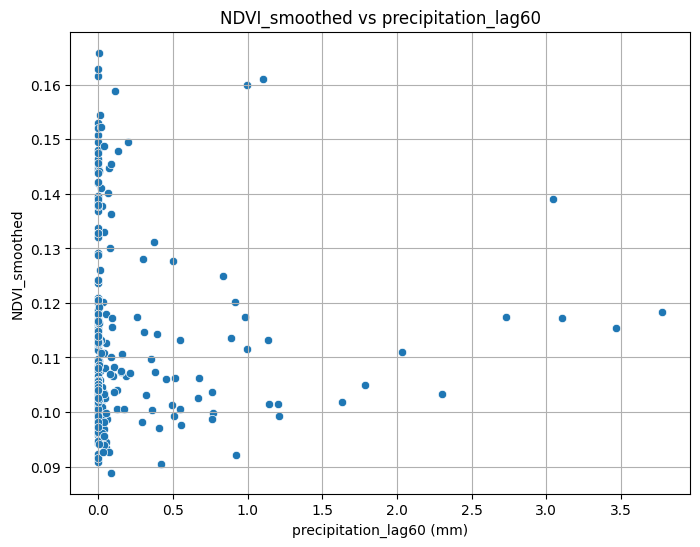

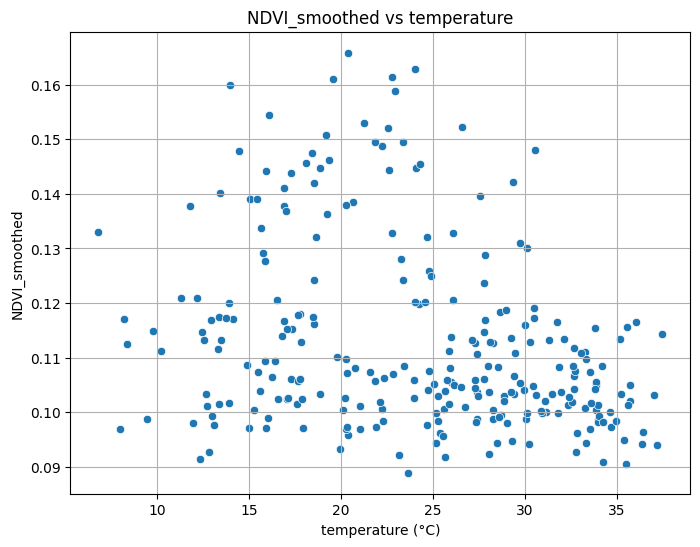

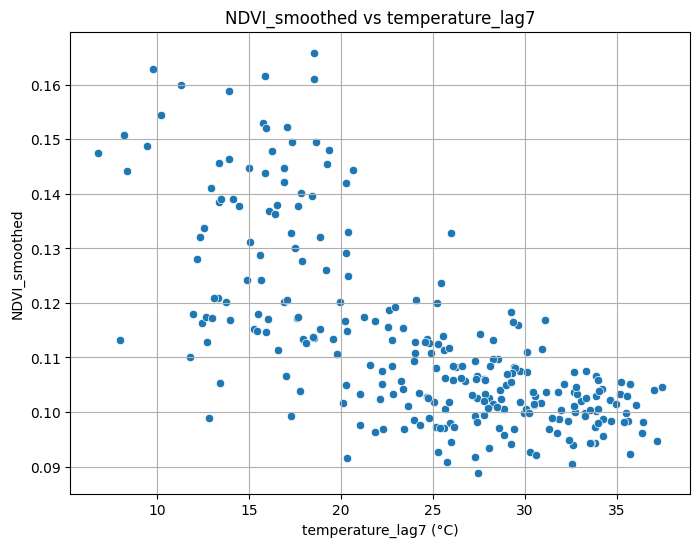

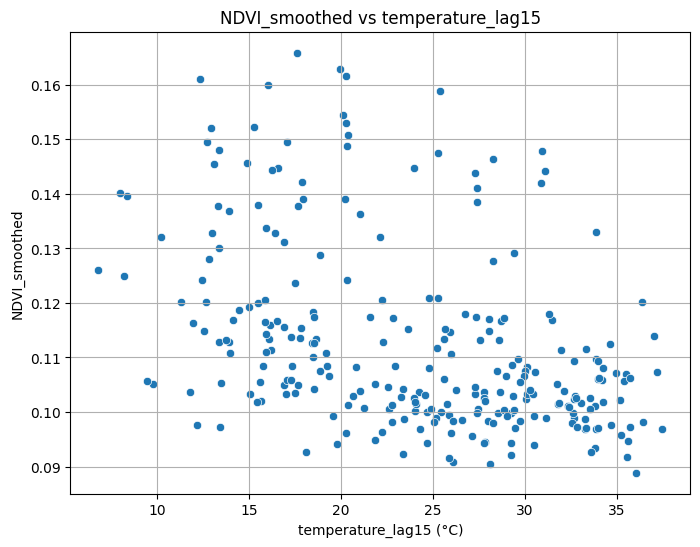

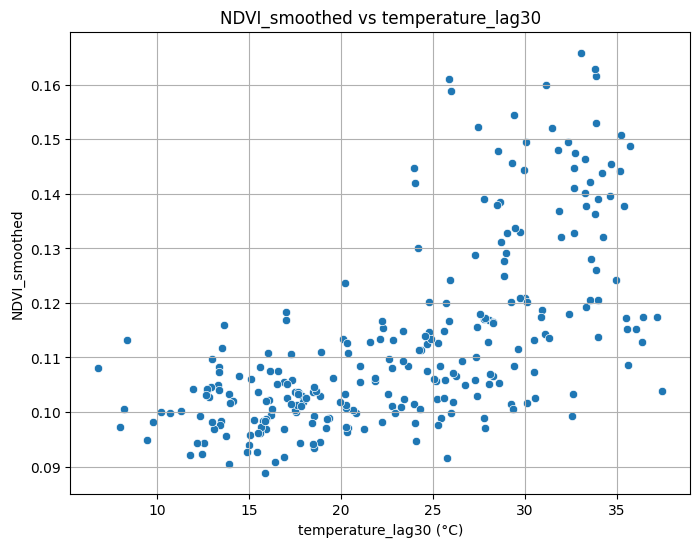

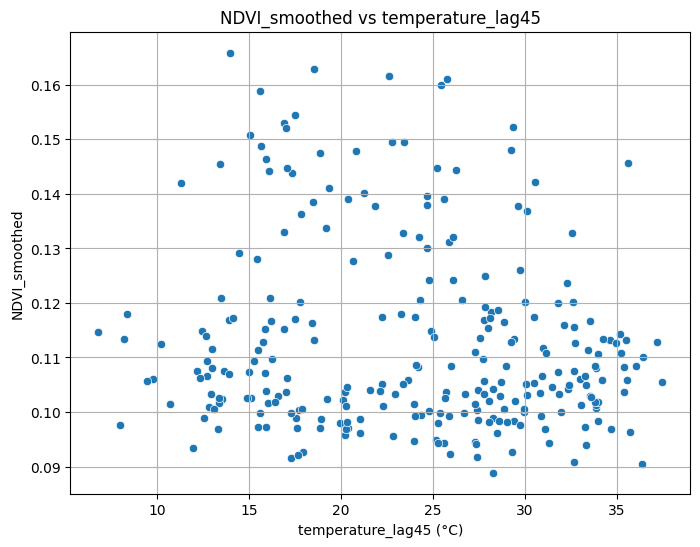

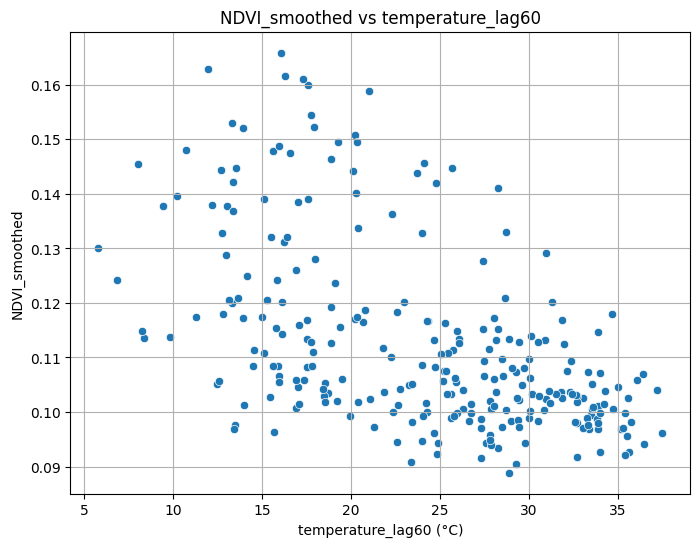

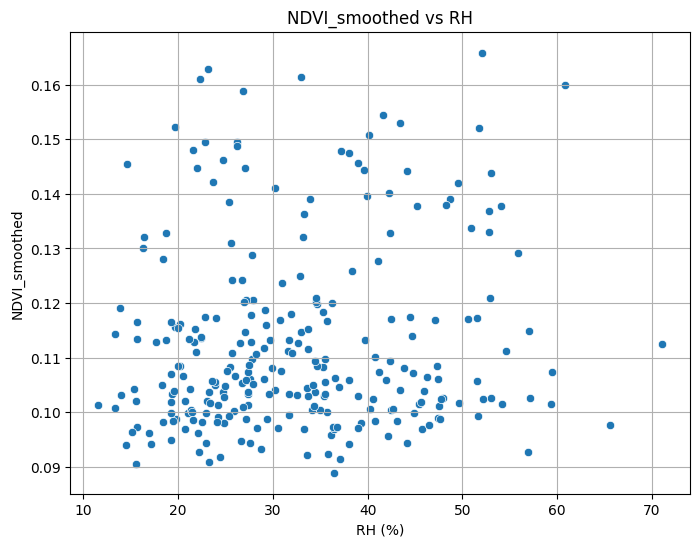

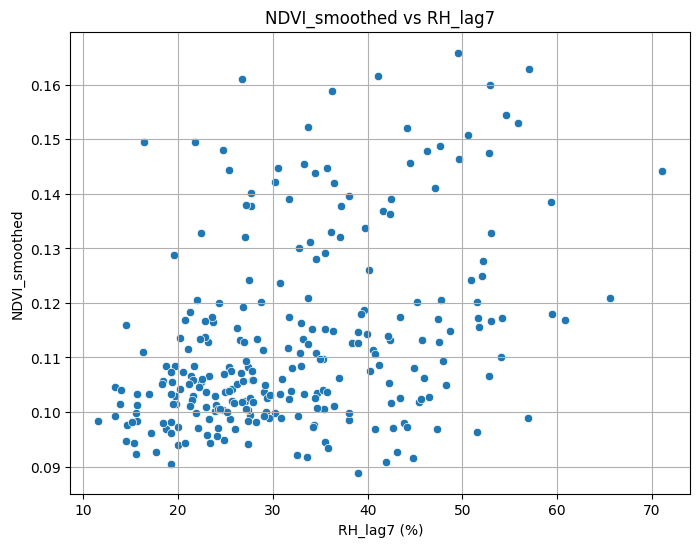

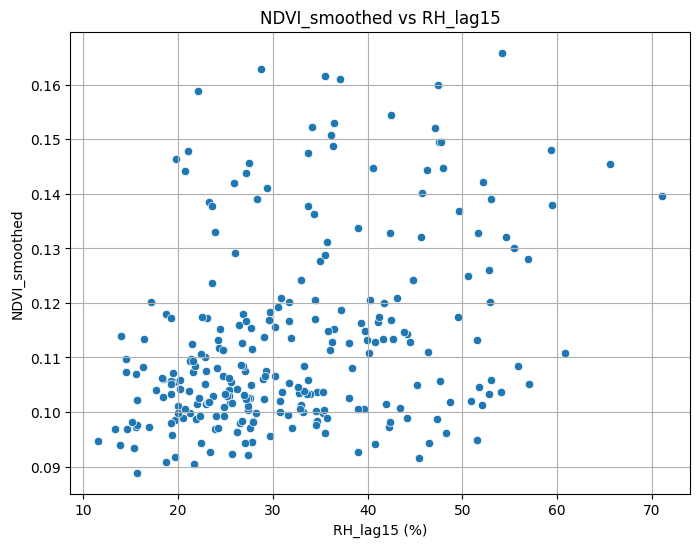

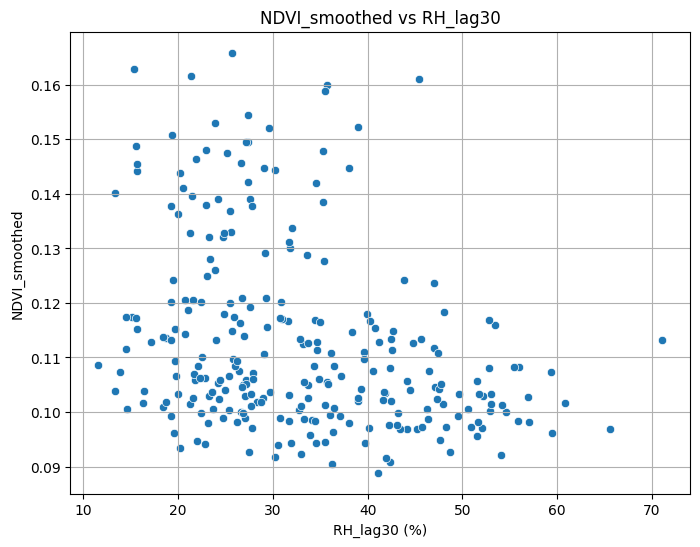

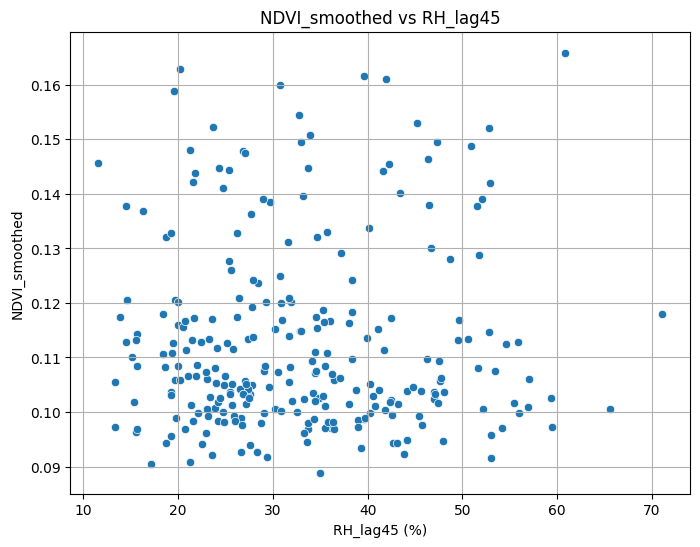

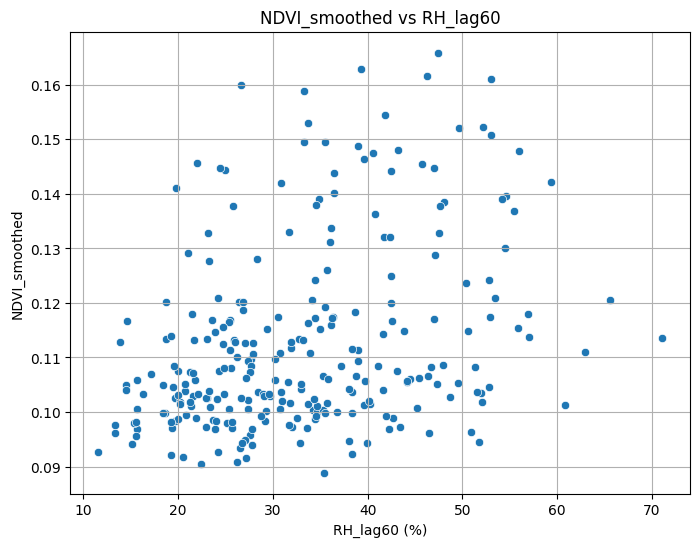

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd  s

# Assurez-vous que df_lag_cleaned est votre DataFrame final
# contenant NDVI_smoothed et toutes les variables météorologiques décalées,
# et qu'il a été nettoyé des NaN introduits par .shift()
VOTRE_DATAFRAME_AVEC_LAGS_NETTOYE = df_lag_cleaned

# Liste des variables météorologiques (originales et décalées) à comparer avec NDVI_smoothed
# Basé sur votre sortie de matrice de corrélation précédente
variables_a_comparer = [
    'precipitation', 'precipitation_lag15', 'precipitation_lag30', 'precipitation_lag45', 'precipitation_lag60',
    'temperature', 'temperature_lag7', 'temperature_lag15', 'temperature_lag30', 'temperature_lag45', 'temperature_lag60',
    'RH', 'RH_lag7', 'RH_lag15', 'RH_lag30', 'RH_lag45', 'RH_lag60'
]

# Variable cible
variable_cible = 'NDVI_smoothed'

# Boucle pour créer un nuage de points pour chaque relation
for var_compare in variables_a_comparer:
    # Vérifier si la colonne existe dans le DataFrame pour éviter les erreurs
    if var_compare in VOTRE_DATAFRAME_AVEC_LAGS_NETTOYE.columns:
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=VOTRE_DATAFRAME_AVEC_LAGS_NETTOYE[var_compare], y=VOTRE_DATAFRAME_AVEC_LAGS_NETTOYE[variable_cible])

        # Titre et labels
        titre_graphique = f'{variable_cible} vs {var_compare}'
        label_x = f'{var_compare}'
        if 'temperature' in var_compare:
            label_x += ' (°C)'
        elif 'precipitation' in var_compare:
            label_x += ' (mm)'
        elif 'RH' in var_compare:
            label_x += ' (%)'

        plt.title(titre_graphique)
        plt.xlabel(label_x)
        plt.ylabel(variable_cible)
        plt.grid(True)
        plt.show()
    else:
        print(f"Attention : La colonne '{var_compare}' n'a pas été trouvée dans le DataFrame.")